In [1]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
import pandas as pd
import numpy as np
from keras.utils import to_categorical
config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
session = tf.Session(config=config)

# 设置session
KTF.set_session(session)

Using TensorFlow backend.


In [2]:
from keras import initializers, regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.callbacks import CSVLogger
from keras.preprocessing.image import ImageDataGenerator

In [16]:
import matplotlib.pyplot as plt

### Load data 

In [3]:
train = pd.read_csv('train.csv',engine='python')
test = pd.read_csv('test.csv',engine='python')

In [4]:
def preprocess_y(train):
    train_y = pd.to_numeric(train['label'])
    train_y = to_categorical(train_y)
    return train_y

def preprocess_x(train):
    train_x = []
    for f in train['feature']:
        temp = np.array(f.split(' ')).astype(int)
        train_x.append(temp)

    train_x = np.array(train_x)
    train_x = train_x.reshape((train_x.shape[0],48,48,1))
    return train_x

In [5]:
train_x = preprocess_x(train)
test_x = preprocess_x(test)
train_y = preprocess_y(train)

In [6]:
floatZoomRange = 0.2
genTrain = ImageDataGenerator(rotation_range=25,
                                       width_shift_range=0.1,
                                       height_shift_range=0.1,
                                       shear_range=0.1, # 水平或垂直投影變換
                                       zoom_range=[1-floatZoomRange, 1+floatZoomRange], # 按比例隨機縮放圖像尺寸
                                       horizontal_flip=True)
genTrain.fit(train_x)

In [14]:
def output_result(filename,predict_value):
    id_ = []
    for i in range(predict_value.shape[0]):
        id_.append(i)
    output = pd.DataFrame(columns=['id','label'])
    output['id'] = id_
    output['label'] = predict_value
    output.to_csv(filename,index = False)
    
    print(output.head())

In [7]:
def get_new_CNN_model():
    model = Sequential() # initializing CNN
    model.add(Convolution2D(64, kernel_size=3, strides=1, padding="same", input_shape=(48, 48, 1), kernel_initializer=initializers.he_normal(seed=None)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.3))

    model.add(Convolution2D(128, kernel_size=3, strides=1, padding="same", kernel_initializer=initializers.he_normal(seed=None)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.3))

    model.add(Convolution2D(256, kernel_size=3, strides=1, padding="same", kernel_initializer=initializers.he_normal(seed=None)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.3))

    model.add(Convolution2D(512, kernel_size=3, strides=1, padding="same", kernel_initializer=initializers.he_normal(seed=None)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.4))

    model.add(Flatten())

    model.add(Dense(512, kernel_initializer=initializers.he_normal(seed=None)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    model.add(Dense(512, kernel_initializer=initializers.he_normal(seed=None)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    model.add(Dense(7))
    model.add(Activation("softmax"))
    optim = Adam()

    model.compile(optimizer=optim, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [8]:
def get_new_DNN_model():
    model = Sequential() # initializing CNN
    model.add(Flatten(input_shape=(48, 48, 1)))

    model.add(Dense(1024))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    model.add(Dense(1024))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    model.add(Dense(1024))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    model.add(Dense(7))
    model.add(Activation("softmax"))
    optim = Adam()
    model.compile(optimizer=optim, loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [12]:
model_dnn = get_new_DNN_model()
model_cnn = get_new_CNN_model()

In [13]:
history_cnn = model_cnn.fit(train_x/255,train_y,batch_size=128,epochs=100,validation_split=0.2)

Train on 22967 samples, validate on 5742 samples
Epoch 1/100
22967/22967 [==============================] - 8s 330us/step - loss: 2.0615 - acc: 0.2351 - val_loss: 1.7835 - val_acc: 0.3069
Epoch 2/100
22967/22967 [==============================] - 6s 256us/step - loss: 1.7439 - acc: 0.3240 - val_loss: 1.6908 - val_acc: 0.3649
Epoch 3/100
22967/22967 [==============================] - 6s 255us/step - loss: 1.5847 - acc: 0.3822 - val_loss: 1.8482 - val_acc: 0.3558
Epoch 4/100
22967/22967 [==============================] - 6s 256us/step - loss: 1.4811 - acc: 0.4261 - val_loss: 1.6079 - val_acc: 0.4110
Epoch 5/100
22967/22967 [==============================] - 6s 256us/step - loss: 1.3999 - acc: 0.4603 - val_loss: 1.4910 - val_acc: 0.4411
Epoch 6/100
22967/22967 [==============================] - 6s 255us/step - loss: 1.3433 - acc: 0.4870 - val_loss: 1.3507 - val_acc: 0.4887
Epoch 7/100
22967/22967 [==============================] - 6s 258us/step - loss: 1.3027 - acc: 0.5000 - val_loss: 1.1

22967/22967 [==============================] - 6s 254us/step - loss: 0.3434 - acc: 0.8760 - val_loss: 1.2692 - val_acc: 0.6372
Epoch 60/100
22967/22967 [==============================] - 6s 257us/step - loss: 0.3376 - acc: 0.8753 - val_loss: 1.2917 - val_acc: 0.6367
Epoch 61/100
22967/22967 [==============================] - 6s 255us/step - loss: 0.3338 - acc: 0.8783 - val_loss: 1.3046 - val_acc: 0.6428
Epoch 62/100
22967/22967 [==============================] - 6s 257us/step - loss: 0.3223 - acc: 0.8841 - val_loss: 1.3821 - val_acc: 0.6325
Epoch 63/100
22967/22967 [==============================] - 6s 257us/step - loss: 0.3163 - acc: 0.8850 - val_loss: 1.2974 - val_acc: 0.6461
Epoch 64/100
22967/22967 [==============================] - 6s 255us/step - loss: 0.3073 - acc: 0.8901 - val_loss: 1.3185 - val_acc: 0.6388
Epoch 65/100
22967/22967 [==============================] - 6s 255us/step - loss: 0.3035 - acc: 0.8906 - val_loss: 1.4061 - val_acc: 0.6285
Epoch 66/100
22967/22967 [=======

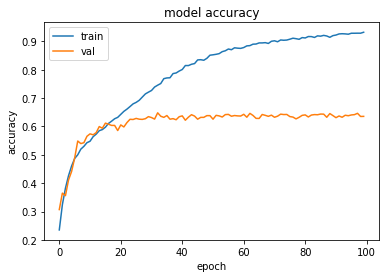

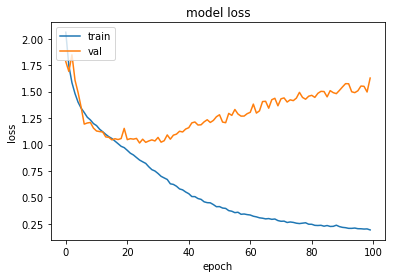

In [22]:
plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
pre_test_cnn = model_cnn.predict_classes(test_x/255,batch_size=128)

In [20]:
output_result('Report_q1_cnn.csv',pre_test_cnn)

   id  label
0   0      3
1   1      4
2   2      3
3   3      5
4   4      6


In [21]:
history_dnn = model_dnn.fit(train_x/255,train_y,batch_size=128,epochs=100,validation_split=0.2)

Train on 22967 samples, validate on 5742 samples
Epoch 1/100
22967/22967 [==============================] - 2s 100us/step - loss: 2.0855 - acc: 0.2524 - val_loss: 1.8009 - val_acc: 0.2793
Epoch 2/100
22967/22967 [==============================] - 1s 48us/step - loss: 1.7814 - acc: 0.3093 - val_loss: 1.6766 - val_acc: 0.3548
Epoch 3/100
22967/22967 [==============================] - 1s 48us/step - loss: 1.6819 - acc: 0.3362 - val_loss: 1.6777 - val_acc: 0.3628
Epoch 4/100
22967/22967 [==============================] - 1s 48us/step - loss: 1.6359 - acc: 0.3621 - val_loss: 1.6447 - val_acc: 0.3607
Epoch 5/100
22967/22967 [==============================] - 1s 48us/step - loss: 1.5976 - acc: 0.3748 - val_loss: 1.6996 - val_acc: 0.2948
Epoch 6/100
22967/22967 [==============================] - 1s 48us/step - loss: 1.5702 - acc: 0.3873 - val_loss: 1.7071 - val_acc: 0.3103
Epoch 7/100
22967/22967 [==============================] - 1s 48us/step - loss: 1.5441 - acc: 0.3991 - val_loss: 1.6791 - 

22967/22967 [==============================] - 1s 49us/step - loss: 0.6985 - acc: 0.7424 - val_loss: 2.0547 - val_acc: 0.3398
Epoch 60/100
22967/22967 [==============================] - 1s 48us/step - loss: 0.6777 - acc: 0.7503 - val_loss: 2.0224 - val_acc: 0.3380
Epoch 61/100
22967/22967 [==============================] - 1s 48us/step - loss: 0.6857 - acc: 0.7471 - val_loss: 1.8391 - val_acc: 0.4046
Epoch 62/100
22967/22967 [==============================] - 1s 48us/step - loss: 0.6517 - acc: 0.7600 - val_loss: 1.8657 - val_acc: 0.3520
Epoch 63/100
22967/22967 [==============================] - 1s 48us/step - loss: 0.6551 - acc: 0.7576 - val_loss: 2.0479 - val_acc: 0.3372
Epoch 64/100
22967/22967 [==============================] - 1s 49us/step - loss: 0.6413 - acc: 0.7623 - val_loss: 2.0200 - val_acc: 0.3703
Epoch 65/100
22967/22967 [==============================] - 1s 48us/step - loss: 0.6316 - acc: 0.7670 - val_loss: 1.9318 - val_acc: 0.3765
Epoch 66/100
22967/22967 [==============

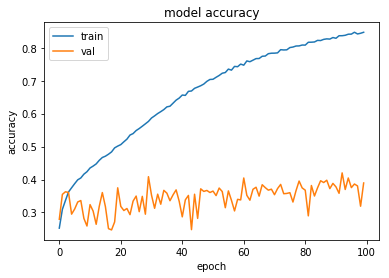

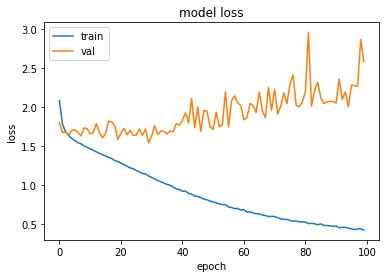

In [23]:
plt.plot(history_dnn.history['acc'])
plt.plot(history_dnn.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_dnn.history['loss'])
plt.plot(history_dnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
pre_test_dnn = model_dnn.predict_classes(test_x/255,batch_size=128)

In [25]:
output_result('Report_q1_dnn.csv',pre_test_dnn)

   id  label
0   0      3
1   1      3
2   2      3
3   3      3
4   4      2


# Data normalization 

In [26]:
model_cnn = get_new_CNN_model()

In [27]:
history_cnn_non = model_cnn.fit(train_x,train_y,batch_size=128,epochs=100,validation_split=0.2)

Train on 22967 samples, validate on 5742 samples
Epoch 1/100
22967/22967 [==============================] - 8s 344us/step - loss: 2.0688 - acc: 0.2309 - val_loss: 1.7500 - val_acc: 0.2677
Epoch 2/100
22967/22967 [==============================] - 6s 261us/step - loss: 1.7506 - acc: 0.3195 - val_loss: 1.7856 - val_acc: 0.3462
Epoch 3/100
22967/22967 [==============================] - 6s 260us/step - loss: 1.5810 - acc: 0.3817 - val_loss: 1.7624 - val_acc: 0.3676
Epoch 4/100
22967/22967 [==============================] - 6s 259us/step - loss: 1.4799 - acc: 0.4301 - val_loss: 1.4798 - val_acc: 0.4399
Epoch 5/100
22967/22967 [==============================] - 6s 260us/step - loss: 1.3973 - acc: 0.4623 - val_loss: 1.3972 - val_acc: 0.4680
Epoch 6/100
22967/22967 [==============================] - 6s 260us/step - loss: 1.3437 - acc: 0.4854 - val_loss: 1.3691 - val_acc: 0.4728
Epoch 7/100
22967/22967 [==============================] - 6s 260us/step - loss: 1.2900 - acc: 0.5041 - val_loss: 1.3

22967/22967 [==============================] - 6s 260us/step - loss: 0.3411 - acc: 0.8800 - val_loss: 1.3350 - val_acc: 0.6405
Epoch 60/100
22967/22967 [==============================] - 6s 261us/step - loss: 0.3407 - acc: 0.8735 - val_loss: 1.3396 - val_acc: 0.6426
Epoch 61/100
22967/22967 [==============================] - 6s 263us/step - loss: 0.3262 - acc: 0.8819 - val_loss: 1.3460 - val_acc: 0.6428
Epoch 62/100
22967/22967 [==============================] - 6s 259us/step - loss: 0.3333 - acc: 0.8772 - val_loss: 1.3248 - val_acc: 0.6437
Epoch 63/100
22967/22967 [==============================] - 6s 260us/step - loss: 0.3102 - acc: 0.8898 - val_loss: 1.3783 - val_acc: 0.6454
Epoch 64/100
22967/22967 [==============================] - 6s 258us/step - loss: 0.3038 - acc: 0.8896 - val_loss: 1.3332 - val_acc: 0.6397
Epoch 65/100
22967/22967 [==============================] - 6s 258us/step - loss: 0.2974 - acc: 0.8935 - val_loss: 1.3647 - val_acc: 0.6409
Epoch 66/100
22967/22967 [=======

In [30]:
pre_test_cnn = model_cnn.predict_classes(test_x,batch_size=128)

In [31]:
output_result('Report_q3_cnn_non.csv',pre_test_cnn)

   id  label
0   0      3
1   1      4
2   2      3
3   3      4
4   4      0


# Data augmentation

In [39]:
model_cnn = get_new_CNN_model()

In [ ]:
history_cnn_aug = model_cnn.fit_generator(genTrain.flow(train_x, train_y, batch_size=128),
                            steps_per_epoch=5*train_x.shape[0]//128, # 每次 batch 所要提取的sample數目為多少
                            verbose=1,
                            epochs=100, shuffle=True)

Epoch 1/100
1121/1121 [==============================] - 34s 30ms/step - loss: 1.7594 - acc: 0.2953
Epoch 2/100
1121/1121 [==============================] - 34s 30ms/step - loss: 1.4483 - acc: 0.4394
Epoch 3/100
1121/1121 [==============================] - 34s 30ms/step - loss: 1.3132 - acc: 0.4971
Epoch 4/100
1121/1121 [==============================] - 34s 30ms/step - loss: 1.2391 - acc: 0.5284
Epoch 5/100
1121/1121 [==============================] - 34s 30ms/step - loss: 1.1923 - acc: 0.5458
Epoch 6/100
1121/1121 [==============================] - 34s 30ms/step - loss: 1.1487 - acc: 0.5630
Epoch 7/100
1121/1121 [==============================] - 34s 30ms/step - loss: 1.1199 - acc: 0.5744
Epoch 8/100
1121/1121 [==============================] - 34s 30ms/step - loss: 1.0979 - acc: 0.5844
Epoch 9/100
1121/1121 [==============================] - 34s 30ms/step - loss: 1.0750 - acc: 0.5916
Epoch 10/100
1121/1121 [==============================] - 49s 44ms/step - loss: 1.0585 - acc: 0.6013

In [ ]:
pre_test_cnn = model_cnn.predict_classes(test_x,batch_size=128)

In [ ]:
output_result('Report_q3_cnn_aug.csv',pre_test_cnn)

# Both 

In [ ]:
bag_train = train.groupby('label').apply(lambda s: s.sample(frac=0.7))
bag_val = train.groupby('label').apply(lambda s: s.sample(frac=0.2))
train_x_ = preprocess_x(bag_train)
train_y_ = preprocess_y(bag_train)
val_x_ = preprocess_x(bag_val)
val_y_ = preprocess_y(bag_val)

In [ ]:
model_cnn = get_new_CNN_model()
history_cnn_aug = model_cnn.fit_generator(genTrain.flow(train_x_/255, train_y_, batch_size=128),
                            steps_per_epoch=5*train_x.shape[0]//128, # 每次 batch 所要提取的sample數目為多少
                            verbose=1,
                            epochs=100, shuffle=True)

## Confusion matrix 

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [ ]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_confusion)

In [33]:
from keras.models import load_model

In [35]:
model_final = load_model('model_data_gen_5.h5')
aa = train['label'].values # true
bb = model_final.predict_classes(train_x/255,batch_size = 128) # predict

In [36]:
cm = confusion_matrix(aa,bb)+1e-9

In [37]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

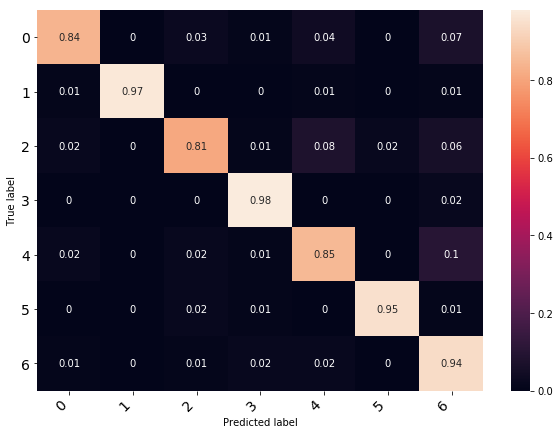

In [38]:
print_confusion_matrix(np.round(cm/cm.sum(axis=1)[:, np.newaxis],2),['Angry','Dsigust','Fear','Happy','Sad','Surprise','Neutral'])